## Experiment Summary

This notebook presents the best-performing model out of four FCNN-based attempts.  
Key improvements in this version include:
- Better preprocessing (missing value imputation)
- One-hot encoding of categorical variables
- Regularization and dropout to prevent overfitting
- Class weighting to handle imbalance

**Final Metrics (Validation):**
- **Accuracy:** 0.88  
- **Precision:** 0.88  
- **Recall:** 0.88  
- **F1-Score:** 0.88


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100
 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6163 - loss: 1.5008
Epoch 1: val_loss improved from inf to 1.35659, saving model to best_model.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.6400 - loss: 1.4548 - val_accuracy: 0.6548 - val_loss: 1.3566 - learning_rate: 0.0010
Epoch 2/100
 6/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7543 - loss: 1.2607
Epoch 2: val_loss improved from 1.35659 to 1.33090, saving model to best_model.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7663 - loss: 1.2505 - val_accuracy: 0.8214 - val_loss: 1.3309 - learning_rate: 0.0010
Epoch 3/100
 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7872 - loss: 1.2395
Epoch 3: val_loss improved from 1.33090 to 1.31347, saving model to best_model.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7849 - loss: 1.2406 - val_accuracy: 0.8095 - val_loss: 1.3135 - learning_rate: 0.0010
Epoch 4/100
 6/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8036 -

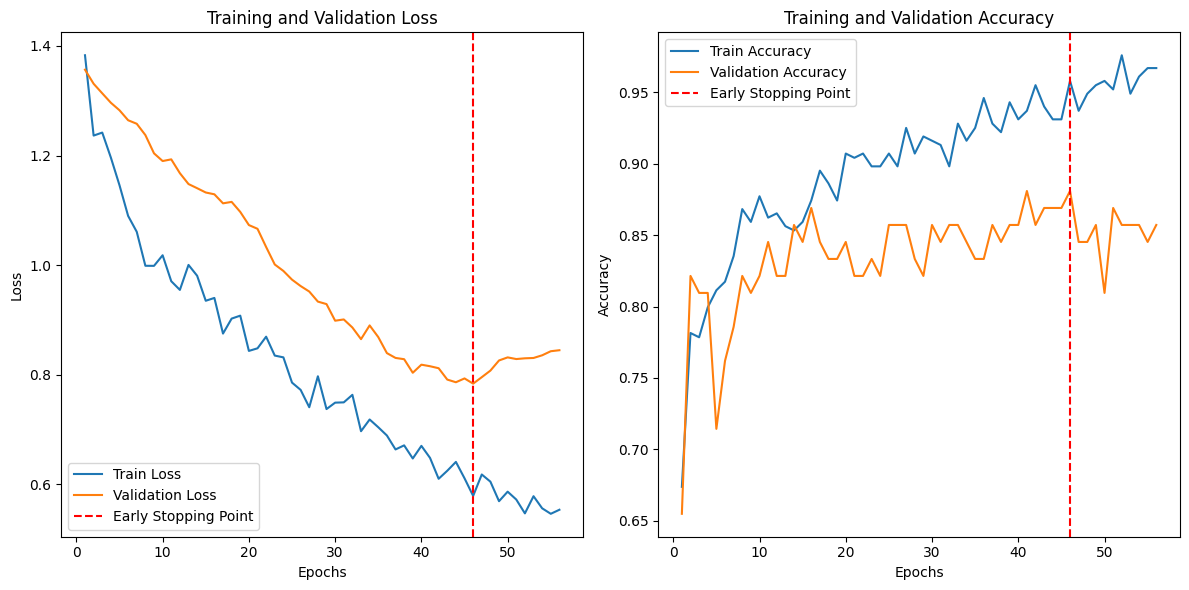

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8819 - loss: 0.7852
Validation Loss: 0.7837517857551575
Validation Accuracy: 0.8809523582458496
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Precision: 0.8828983516483517
Recall: 0.8809523809523809
F1-Score: 0.8798319327731092

Classification Report:

              precision    recall  f1-score   support

       False       0.87      0.94      0.90        48
        True       0.91      0.81      0.85        36

    accuracy                           0.88        84
   macro avg       0.89      0.87      0.88        84
weighted avg       0.88      0.88      0.88        84



In [10]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Data reading
file_path = '/content/cirrhosis.csv'
df = pd.read_csv(file_path)

# Handling Missing Values
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns
#Numbers: Fill in the value of the median (the middle number in the table, to avoid the influence of outlier values).
#Text: Fill in the value that appears most frequently (the mode).
df[numerical_columns] = df[numerical_columns].fillna(df[numerical_columns].median())
df[categorical_columns] = df[categorical_columns].fillna(df[categorical_columns].mode().iloc[0])

# One-Hot Encoding for Categories
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Defining the Target Column and Features
target_column = 'Status_D'  # Binary Status (Assumption: 'D' is positive)
X = df.drop(columns=[col for col in df.columns if col.startswith('Status_')]).values
y = df[target_column].values

# Splitting the data into training and validation sets (80% for training, 20% for testing)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Data normalization
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Definition of the model
def create_model(input_dim, learning_rate=0.001, dropout_rate=0.3):
    model = Sequential()

    #Input layer 256 neurons with regulation 12
    model.add(Dense(256, input_dim=input_dim, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(LeakyReLU(alpha=0.1))
    #Turn off 30% of the neurons each time to prevent overfitting
    model.add(Dropout(dropout_rate))
    # Normalizing the values in each layer.
    model.add(BatchNormalization())

    # Hidden layers: 512 neurons and then 256 neurons.

    model.add(Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())

    model.add(Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
   # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # optimizer
    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Treatment of data imbalance
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train)

# Definition of callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Model Building
model = create_model(input_dim=X_train.shape[1], learning_rate=0.001, dropout_rate=0.3)

#Model Training
#The model goes through all the data 100 times, each time the model learns 32 examples.
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    class_weight=dict(enumerate(class_weights)),
    callbacks=[early_stop, lr_scheduler, checkpoint])

# Early stopping
stopped_epoch = early_stop.stopped_epoch + 1
print(f"Early stopping {stopped_epoch}")

# history training
history_dict = history.history

train_losses = history_dict['loss']
val_losses = history_dict['val_loss']
accuracies = history_dict['accuracy']
val_accuracies = history_dict['val_accuracy']

best_epoch = np.argmin(val_losses)

# Loss Graph (Training Set vs Validation Set)
plt.figure(figsize=(12, 6))

# Left: Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.axvline(x=best_epoch+1, color='red', linestyle='--', label='Early Stopping Point')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Right: Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(accuracies)+1), accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Validation Accuracy')
plt.axvline(x=best_epoch+1, color='red', linestyle='--', label='Early Stopping Point')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

predictions = model.predict(X_val)
predicted_classes = (predictions > 0.5).astype(int).flatten()

true_classes = y_val

precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

# Detailed report
print("\nClassification Report:\n")
print(classification_report(true_classes, predicted_classes))